In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#pull data
unsorted_data = pd.DataFrame.from_csv("/Users/Mahir/Documents/Personal/Comp Sci/analyzing_lesions/clinical_info.csv").drop('mse',axis=1)
#gather only SP and RR from available cohort
rr = unsorted_data['dc'] == 'RR'
sp = unsorted_data['dc'] == 'SP'
rr_df = unsorted_data[rr]
sp_df = unsorted_data[sp]
scores_lesion = rr_df.append(sp_df)
scores_lesion.head(10)

,total_lesions,max_lesion_volume,min_lesion_volume,total_volume_of_lesions,average_volume,median_volume,inf_total_lesions,inf_max_lesion_volume,inf_min_lesion_volume,inf_total_volume_of_lesions,...,sub_max_lesion_volume,sub_min_lesion_volume,sub_total_volume_of_lesions,sub_average_volume,sub_median_volume,edss,dc,dd,msfc 25 1,msfc 25 2
0,15,429.0,15.0,1661.0,110.733333,72.0,1,53.0,53.0,53.0,...,79.0,15.0,155.0,51.666667,61.0,3.5,RR,35.0,6.3,6.1
1,16,4427.0,44.0,9706.0,606.625000,108.5,0,0.0,0.0,0.0,...,4427.0,44.0,5092.0,727.428571,108.0,2.0,RR,9.0,4.6,4.7
2,6,81.0,40.0,346.0,57.666667,55.5,0,0.0,0.0,0.0,...,81.0,43.0,241.0,60.250000,58.5,2.0,RR,15.0,3.8,3.6
4,3,123.0,72.0,310.0,103.333333,115.0,0,0.0,0.0,0.0,...,72.0,72.0,72.0,72.000000,72.0,0.0,RR,0.0,4.0,4.2
5,7,358.0,75.0,1250.0,178.571429,168.0,0,0.0,0.0,0.0,...,168.0,75.0,243.0,121.500000,121.5,1.5,RR,5.0,4.3,4.2
6,15,3584.0,19.0,10451.0,696.733333,336.0,0,0.0,0.0,0.0,...,3584.0,19.0,4031.0,806.200000,176.0,3.0,RR,14.0,4.9,4.7
8,12,1193.0,20.0,2348.0,195.666667,56.0,0,0.0,0.0,0.0,...,243.0,20.0,699.0,87.375000,56.0,4.0,RR,20.0,4.5,4.4
12,16,2306.0,16.0,5154.0,322.125000,89.0,0,0.0,0.0,0.0,...,844.0,27.0,1256.0,179.428571,50.0,1.0,RR,28.0,4.4,4.5
13,28,917.0,18.0,4287.0,153.107143,79.0,0,0.0,0.0,0.0,...,917.0,18.0,2898.0,181.125000,69.0,1.0,RR,3.0,4.2,4.0
14,10,943.0,41.0,1996.0,199.600000,94.5,0,0.0,0.0,0.0,...,274.0,106.0,380.0,190.000000,190.0,1.0,RR,1.0,4.0,4.3


## ROC and Permutation Test

Classification score: 0.929 (p value: 0.00990)


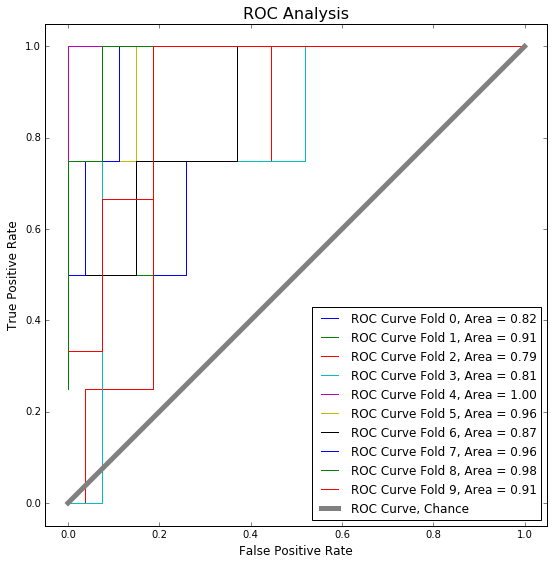

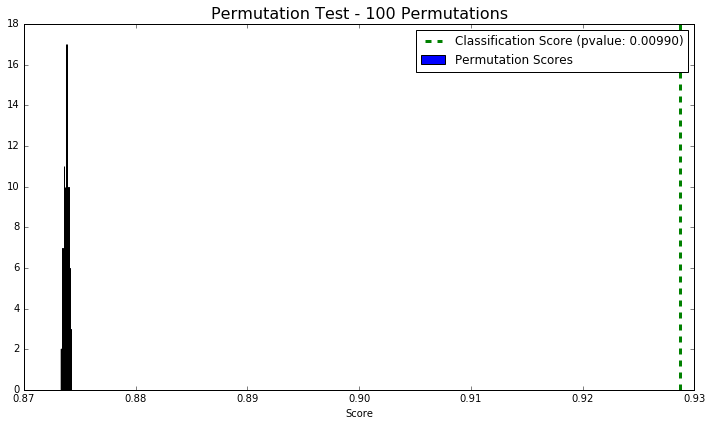

In [2]:
from sklearn import svm
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold, permutation_test_score

#set X and y values

#X values are (309,3) array, accounting for total juxtacortical lesions, total lesions, and EDSS scores as features
X_values=scores_lesion[['jux_total_lesions','total_lesions','edss']].values
#y values are (309,) array, accounting for one of two disease courses, which is then binarized for ROC analysis
y_values=label_binarize(scores_lesion.dc.values, classes=['RR','SP']).ravel()

#set classifier and cross validation technique
cv = StratifiedKFold(y_values, n_folds=10)
clf = svm.SVC(kernel="linear", C=1, probability=True)

#calculate permutations
score, perm_score, pvalue = permutation_test_score(clf,
                                                   X_values,
                                                   y_values,
                                                   scoring="accuracy",
                                                   cv=cv,
                                                   n_permutations=100,
                                                   n_jobs=1)
print("Classification score: %2.3f (p value: %2.5f)" % (score,pvalue))

#calculate and plot ROC curves for each KFold
plt.figure(figsize=(9,9))
for i,(train,test) in enumerate(cv):
    clf = clf.fit(X_values[train], y_values[train])
    prob = clf.predict_proba(X_values[test])
    fpr, tpr, thres = roc_curve(y_values[test],prob[:,1])
    auc_data = auc(fpr,tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label="ROC Curve Fold %d, Area = %0.2f" % (i, auc_data))
plt.plot([0,1],[0,1],
         lw=5,
         label="ROC Curve, Chance",
         color='gray')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate',size=12)
plt.ylabel('True Positive Rate',size=12)
plt.title('ROC Analysis', size=16)
plt.legend(loc='lower right')

#plot permutations test
plt.figure(figsize=(10,6))
plt.hist(perm_score,20,label="Permutation Scores")
ylim=plt.ylim()
plt.plot([score,score],ylim,'--g',linewidth=3,label = 'Classification Score (pvalue: %2.5f)' %pvalue)
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.title('Permutation Test - 100 Permutations',size=16)

#show both plots
plt.tight_layout()
plt.show()

## Code Created during Learning Process

In [ ]:
#basic cv test
from sklearn import svm
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn import metrics

#set X and y values
X_values=scores_lesion[['inf_total_lesions','inf_total_volume_of_lesions']]
y_values=scores_lesion.dc

X_train,X_test,y_train,y_test = cross_validation.train_test_split(X_values,y_values,test_size=0.50,random_state=0)

#set classifier
clf = svm.SVC(kernel='poly', C = 1,degree=2).fit(X_train,y_train)
prediction = clf.predict(X_test)

#determine number of correct and incorrect
number_correct = 0
number_wrong = 0
for count in range(len(y_test)):
    if prediction[count] == y_test.values[count]:
        number_correct += 1
    else:
        number_wrong += 1
print "Correct: {}  Incorrect: {}".format(number_correct,number_wrong)

In [ ]:
#basic scatterplot
print len(y_values)

x = scores_lesion.edss
y = scores_lesion.inf_total_volume_of_lesions
fit = np.polyfit(x,y,1)
fit_fn=np.poly1d(fit)

plt.figure(figsize=(10,8))
plt.plot(x,y,'yo',x,fit_fn(x),'--k')
plt.xlabel('EDSS')
plt.xlim(-1,)
plt.ylim(-1,)
plt.show()